# ПРОЕКТ
# Разработка модели машинного обучения для определения возраста покупателей по фотографии

## Постановка задачи

Заказчику - сетевому супермаркету **«Хлеб-Соль»**, в связи с внедрением системы компьютерного зрения для обработки фотографий покупателей, необходимо разработать модель, которая бы определяла **приблизительный** возраст покупателя по фотографии, сделанной в прикассовой зоне в момент совершения покупки.

Информация о возрасте покупателя может быть использована магазином, в том числе для:
- анализа покупкок и предложения товаров, которые могут заинтересовать покупателей той или иной возрастной группы;
- контроля кассиров при продаже алкоголя.

Необходимо:
- разработать модель машинного обучения (задача регрессии, обучение с учителем) на основании имеющегося датасета с фотографиями людей и указанием возраста.

Требования к модели:
- метрика оценки качества - **МАЕ**
- значение метрики качества - **менее 8**.


**Порядок выполнения проекта:**

Проект будет выполнен в 2 этапа:

- исследовательский анализ данных имеющегося датасета;
- формирование и обучение модели машинного обучения на GPU-тренажере.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
files = '/datasets/faces/final_files/'

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=files,
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32,
        class_mode='raw', seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


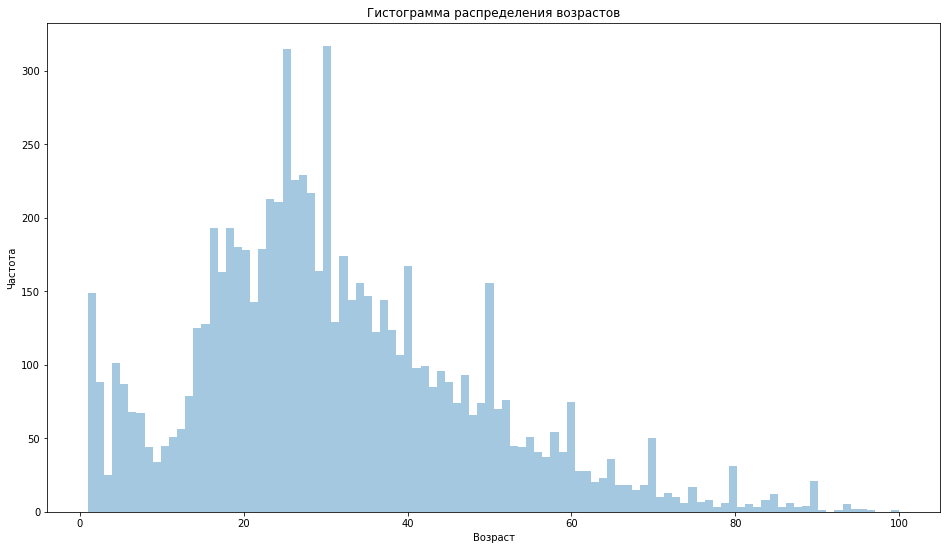

In [ ]:
plt.figure(figsize=(16,9))
sns.distplot(labels.real_age, kde=False, bins=100)
plt.title("Гистограмма распределения возрастов")
plt.xlabel("Возраст")
plt.ylabel("Частота")

plt.show()

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошая визуализация!
</div>

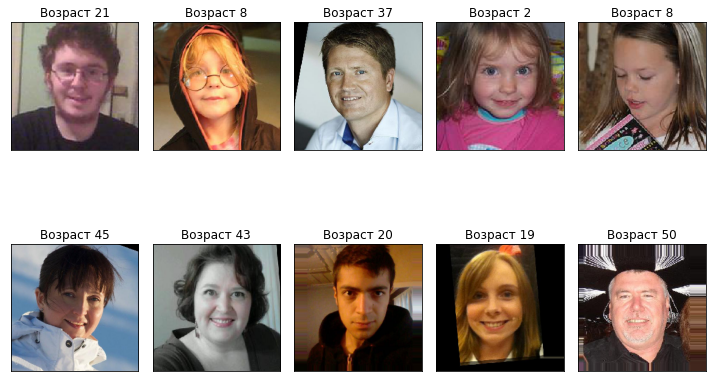

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('Возраст ' + str(target[i]))
    plt.tight_layout()

<div class="alert alert-block alert-info">
<b>Совет: </b> В названиях (title) изображений можно указать возраст.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Сделано! Да, так лучше выглядит. Спасибо!
</div>

In [ ]:
print(features.shape)

(32, 224, 224, 3)


**ВЫВОД по разделу:**
В исследуемом датасете представлено **7 591** файлов изображений, данного количества вполне достаточно для обучения нейронной сети.

Поле **real_age** не содержит пропусков т.е. разметка проведена для всех имеющихся изображений.

Обращает на себя внимание наличие пиков по "круглым" возрастам, начиная с 25 лет, далее 30 и далее каждые 10 лет. Вероятно, это может быть связано с тем, что при разметке использовались не анкетные данные, а оценка возраста по возрастным группам.

Все фото портретные, т.е. основную часть фото занимает лицо, но при этом имеются как черно-белые,  так и цветные фото, а также фото в анфас и в профиль. Последний фактор может повлиять на качество обучения модели. Применим горизонтальный флип, если метрика будет недостаточной без него.

## Обучение модели

Код обучения модели сверточной нейронной сети:

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255)   #horizontal_flip=True,
    labels = pd.read_csv(path + '/labels.csv')
    files = path + '/final_files'
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, directory=files,
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32,
        class_mode='raw', subset='training', seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255)
    labels = pd.read_csv(path + '/labels.csv')
    files = path + '/final_files'
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=files,
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32,
        class_mode='raw', subset='validation', seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(90, activation='relu'))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(lr=0.0001)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

Результат обучения модели в GPU-тренажере:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/7
178/178 - 62s - loss: 262.5392 - mae: 11.5729 - val_loss: 477.5606 - val_mae: 16.7932
Epoch 2/7
178/178 - 50s - loss: 61.2683 - mae: 5.9000 - val_loss: 650.7609 - val_mae: 20.4465
Epoch 3/7
178/178 - 49s - loss: 27.8015 - mae: 4.0497 - val_loss: 315.7870 - val_mae: 13.0914
Epoch 4/7
178/178 - 47s - loss: 19.2944 - mae: 3.3679 - val_loss: 136.3418 - val_mae: 8.9938
Epoch 5/7
178/178 - 45s - loss: 13.5744 - mae: 2.8369 - val_loss: 87.6556 - val_mae: 7.2980
Epoch 6/7
178/178 - 46s - loss: 9.1876 - mae: 2.3170 - val_loss: 67.2862 - val_mae: 6.2185
Epoch 7/7
178/178 - 45s - loss: 8.4576 - mae: 2.2145 - val_loss: 69.7359 - val_mae: 6.4777
WARNING:tensorflow:sample_weight modes were coerced from
 ...
 to
 ['...']
60/60 - 10s - loss: 69.7359 - mae: 6.4777
Test MAE: 6.4777


```

**ВЫВОД по разделу:**

Все файлы, имеющиеся в датасете, успешно применены при обучении модели (5 694 - для обучающей выборки и 1897 - для тестовой).

Требуемое значение метрики МАЕ - не больше 8, по результатам обучения модели - достигнутое значение метрики = **6.47**, т.е. требуемое качество работы модели достигнуто.

<div class="alert alert-block alert-success">
<b>Успех:</b> Модель определена верно. Отлично, что ты попробовал применить аугменатцию к тренировочной части данных (видимо попробовал*)!
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Да, но и без нее метрика получилась лучше требуемой, поэтому не стал ее включать, чтоб не увеличивать время обучения.  ;-)
</div>

## Анализ обученной модели

**ОБЩИЙ ВЫВОД по Проекту:**

Заказчику - сетевому супермаркету «Хлеб-Соль» необходимо было разработать модель машинного обучения для определения приблизительного возраста покупателей по фотографии.
Для обучения модели имелся в наличии размеченный датасет на **7 591** фотографий людей с указанным возрастом.
Требование по качеству модели - по метрика **МАЕ - не более 8**.

В результате выполнения проекта была разработана модель на основе сверточной нейронной сети на архитектуре **ResNet50** c оптимизатором **Adam**.

Для сокращения времени обучения модели были применены следующие шаги:
- использование сокращенной архитектуры ResNet50 (параметр include_top=**False**);
- использование весов, рассчитанных на предобученной нейронной сети **imagenet**;
- применение функции потерь средняя квадратическая ошибка (**mean squared error**).

В результате полученная модель показала значение метрики MAE на тестовой выборке = **6.47**, что существенно ниже минимального требуемого порога качества модели, определенного заказчиком.

Обучение модели проведено на 7 эпохах, общее время обучения составило **5,9 минут**.
